


## Data Generator setups

In [1]:
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt


generator_args = dict(
        rotation_range=180,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255, 
        brightness_range=[0.5, 1.2],
        shear_range=0.02,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='reflect',
        data_format='channels_last')
input_shape = (64, 64)
batch_size = 10
data_flow_args = dict(
    target_size=input_shape,
    batch_size=batch_size,
    color_mode="grayscale",
    class_mode=None)

# below is just to make sure my setup is correctly adjusted 
##########################################################################
# datagen = ImageDataGenerator(**generator_args)
# img = load_img('images/image1.png')  # this is a PIL image
# img = img.convert('L')
# x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
# x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# # the .flow() command below generates batches of randomly transformed images
# # and saves the results to the `preview/` directory
# i = 0
# for batch in datagen.flow_from_directory('images', batch_size=1, color_mode="grayscale",target_size=(256,256),
#                           save_to_dir='preview', save_prefix='im', save_format='jpeg',class_mode=None):
#     # print(np.array_equal(batch[0], batch[1]))
#     print(batch[0].max())
#     j = 1
#     for batch_x in batch:
#         print(batch_x.size)
#         x = Image.fromarray((np.reshape(batch_x,(256,256))))
#         # x.show()
#         # print(batch_x
#         j+=1
#     i += 1
#     if i > 0:
#         break  # otherwise the generator would loop indefinitely
####################################################################

## train images

Found 10 images belonging to 1 classes.


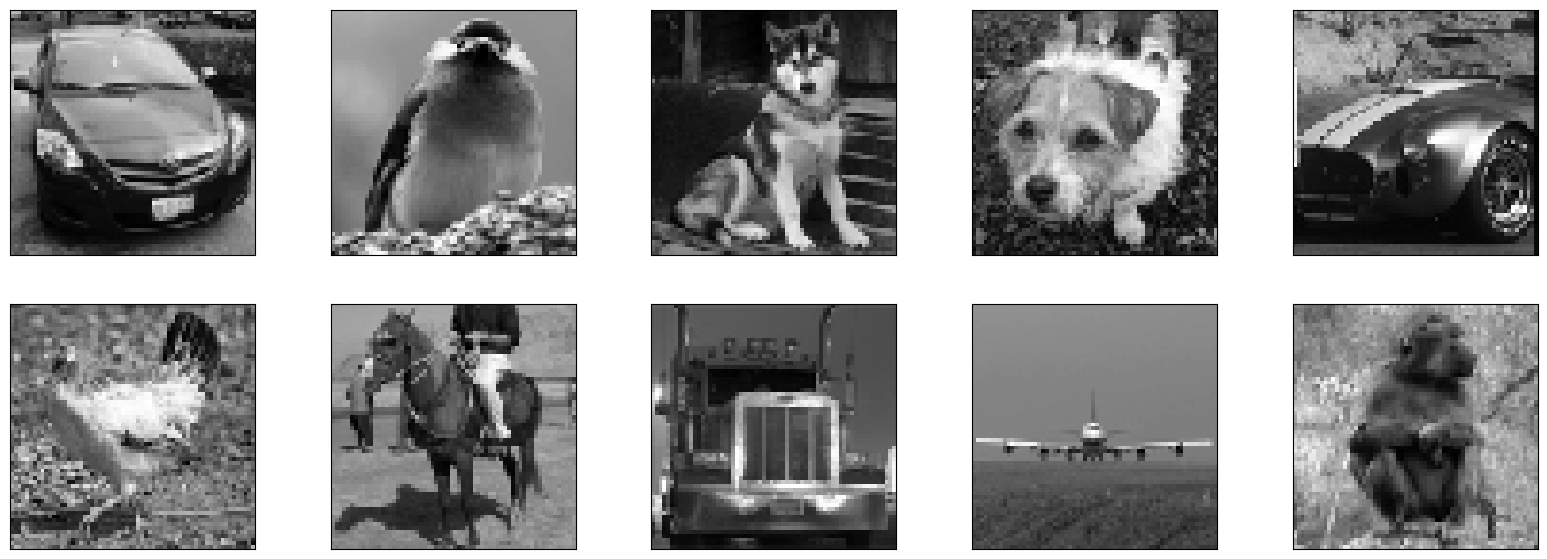

In [2]:
datagen = ImageDataGenerator(       
        rotation_range=0,
        width_shift_range=0,
        height_shift_range=0.0,
        rescale=1./255, 
        shear_range=0.0,
        zoom_range=0,
        horizontal_flip=False,
        fill_mode='reflect',
        data_format='channels_last')
x = next(datagen.flow_from_directory('images',**data_flow_args))

 
plt.figure(figsize=(20, 7))
for i in range(1,batch_size+1-5): 
    ax = plt.subplot(2, batch_size+1-6, i)
    plt.imshow(x[i-1])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, batch_size+1-6, i+5)
    plt.imshow(x[i-1+5])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### example of what a batch can be, (before adding noise) 

Found 10 images belonging to 1 classes.


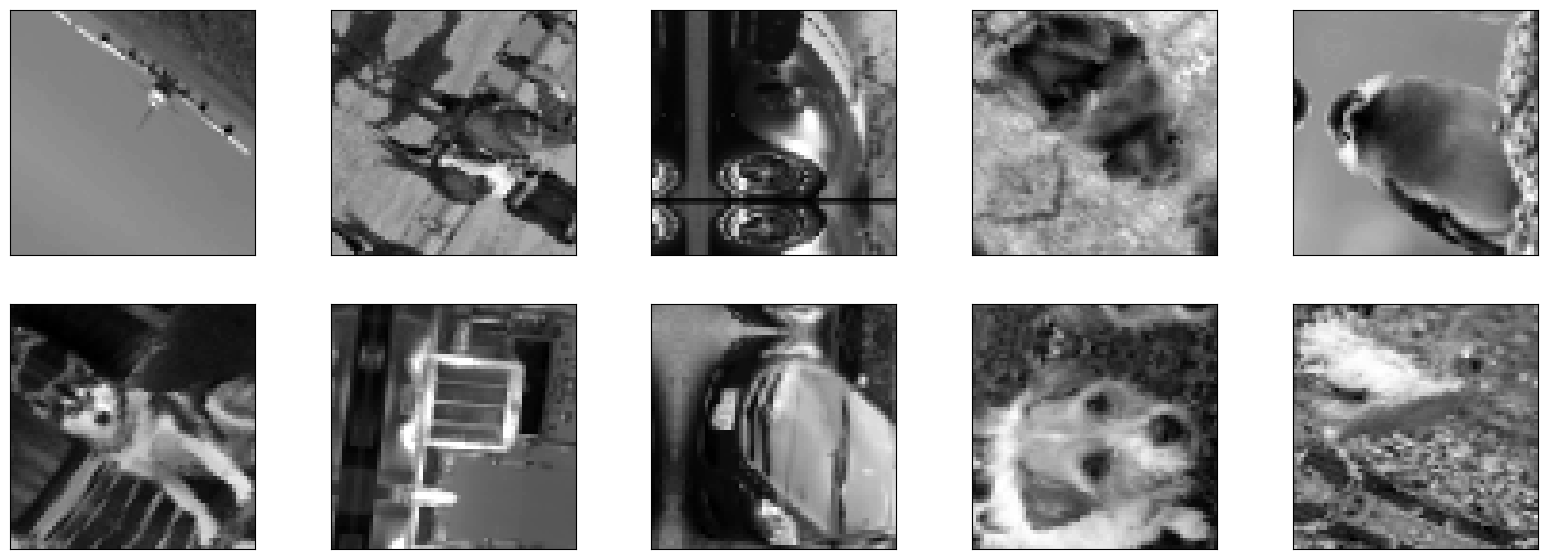

In [3]:
datagen = ImageDataGenerator(**generator_args)
x = next(datagen.flow_from_directory('images',**data_flow_args))

 
plt.figure(figsize=(20, 7))
for i in range(1,batch_size+1-5): 
    ax = plt.subplot(2, batch_size+1-6, i)
    plt.imshow(x[i-1])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, batch_size+1-6, i+5)
    plt.imshow(x[i-1+5])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Noise

I set the sigma between 0.03 to 0.11 
The images are small, and adding significant noise makes detecting shapes almost impossible. Additionally, if the noise level becomes too high, there is a risk that the model may overfit, performing well only on the training data.
#### here an Example of sigma = 0.1

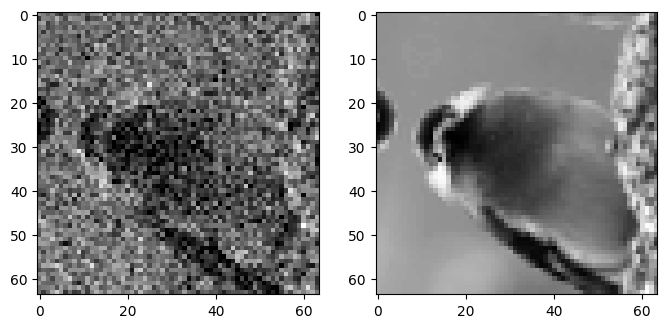

In [4]:
# example
noise = np.random.normal(scale=.1, size=x[0].shape)
batch_noisy = np.clip(x[4] + noise, 0, 1)
plt.figure(figsize=(8, 4))
ax = plt.subplot(1, 2, 1)
plt.imshow(batch_noisy)
plt.gray()
ax = plt.subplot(1, 2, 2)
plt.imshow(x[4])
plt.gray()
plt.show()

## Noise Function
#### Here is the function for create Noise, it take each batch and add noise, then the orginal input will be y and noisy output is x

In [5]:
# as mentaioned above
def nois_generator(batches):
    for batch_x in batches:
        sigma = np.random.uniform(low=0.03, high=0.11) # random sigma
        noise = np.random.normal(scale=sigma, size=batch_x.shape)
        batch_noisy = np.clip(batch_x + noise, 0, 1)
        yield (batch_noisy, batch_x)
def nois_generator_for_test(batches,sigma): # this function have a input sigma for test data
    for batch_x in batches:
        noise = np.random.normal(scale=sigma, size=batch_x.shape)
        batch_noisy = np.clip(batch_x + noise, 0, 1)
        yield (batch_noisy, batch_x)

In [6]:
import keras.layers as layers
import keras.models as models
from keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
from keras.initializers import orthogonal

#### AutoEncoder structure
As I mentioned above, I drew inspiration from this paper. https://arxiv.org/abs/2307.12255
But because there are a few train data I add a Dropout layer with 20 percent to avoide overfitting

In [7]:

inputs = layers.Input(shape=(64, 64, 1))
#64 * 64
x = layers.Conv2D(32, 3, strides=1, padding='same')(inputs)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.2)(x)
block1 = layers.BatchNormalization()(x)

x = layers.Conv2D(64, 3, strides=2, padding='same')(block1)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.2)(x)
block2 = layers.BatchNormalization()(x)

# #32 * 32

x = layers.Conv2D(128, 3, strides=2, padding='same')(block2)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.2)(x)
block3 = layers.BatchNormalization()(x)

#16 * 16
x = layers.Conv2D(256, 3, strides=2, padding='same')(block3)
x = layers.LeakyReLU()(x)
x = layers.Dropout(.2)(x)
block4 = layers.BatchNormalization()(x)

# 8 * 8
# ############################
x = layers.Conv2DTranspose(256, 3, strides=2, padding='same')(block4)
x = layers.LeakyReLU()(x)
x = layers.Dropout(.2)((x))
block5 = layers.BatchNormalization()(x)
# 16 * 16
concat1 = layers.concatenate([block5, block3])
x = layers.Conv2DTranspose(128, 3, strides=2, padding='same')(concat1)
x = layers.LeakyReLU()(x)
x = layers.Dropout(.2)((x))
block6 = layers.BatchNormalization()(x)
# 32 * 32
concat2 = layers.concatenate([block6, block2])
x = layers.Conv2DTranspose(64, 3, strides=2, padding='same')(concat2)
x = layers.LeakyReLU()(x)
x = layers.Dropout(.2)((x))
block7 = layers.BatchNormalization()(x)
# # 64 *64
concat3 = layers.concatenate([block7, block1])
x = layers.Conv2DTranspose(32, 3, strides=1, padding='same')(concat3)
x = layers.LeakyReLU()(x)
x = layers.Dropout(.2)((x))
block8 = layers.BatchNormalization()(x)

decoded = layers.Conv2DTranspose(1, 3, strides=1, padding='same',activation='sigmoid')(block8)
autoencoder = models.Model(inputs, decoded)

#### using ExponentialDecay for Learning rate

In [8]:
epochs = 150
train_size = 10
initial_learning_rate = 0.002
final_learning_rate = 0.0001
learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/epochs)
steps_per_epoch = int(train_size/batch_size)
## Optimizer
lr_schedule = ExponentialDecay(
    initial_learning_rate = initial_learning_rate,
    decay_steps=steps_per_epoch,
    decay_rate=learning_rate_decay_factor,
    staircase=True)

opt = Adam(learning_rate=lr_schedule)
autoencoder.compile(optimizer=opt, loss='mse', metrics=['accuracy'])
# autoencoder.summary()

In [9]:
train_datagen = ImageDataGenerator(**generator_args)
val_datagen = ImageDataGenerator(**generator_args)

train_batches = train_datagen.flow_from_directory(
    'images',
    **data_flow_args)

val_batches = val_datagen.flow_from_directory(
    'images',
    **data_flow_args)


train_noisy = nois_generator(train_batches)
val_noisy = nois_generator(val_batches)


Found 10 images belonging to 1 classes.
Found 10 images belonging to 1 classes.


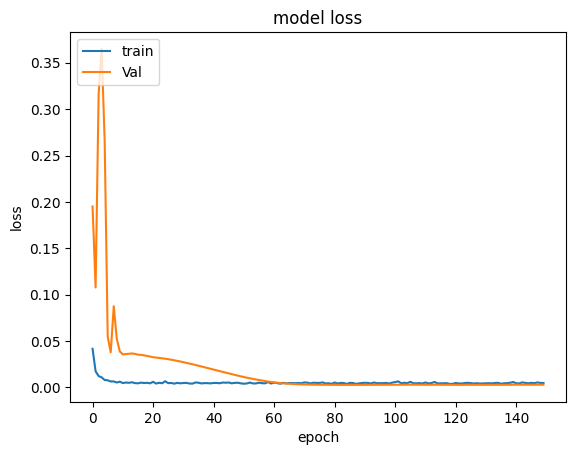

In [10]:
history = autoencoder.fit(train_noisy,
                    steps_per_epoch = train_batches.samples, ######## IMPORTANT: steps per epochs is 10, it means  backpropagation 
                    epochs=epochs,                           ######## calculate for each data, its a little slow but have best resultes
                    verbose=0, 
                    validation_data = val_noisy,
                    validation_steps = train_batches.samples // batch_size)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Val'], loc='upper left')
plt.show()


# TEST

In [11]:
generator_args = dict(
        rotation_range=0,
        width_shift_range=0,
        height_shift_range=0,
        rescale=1./255, 
        shear_range=0.0,
        zoom_range=0.,
        horizontal_flip=False,
        fill_mode='reflect',
        data_format='channels_last')
test_datagen = ImageDataGenerator(**generator_args)

test_batches = test_datagen.flow_from_directory(
     'testimages',
    **data_flow_args)



Found 8 images belonging to 1 classes.


### TEST data with $\sigma$ = 0.05

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step - accuracy: 0.0045 - loss: 0.0039
Test loss: 0.00387061876244843
Test accuracy: 0.00445556640625
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


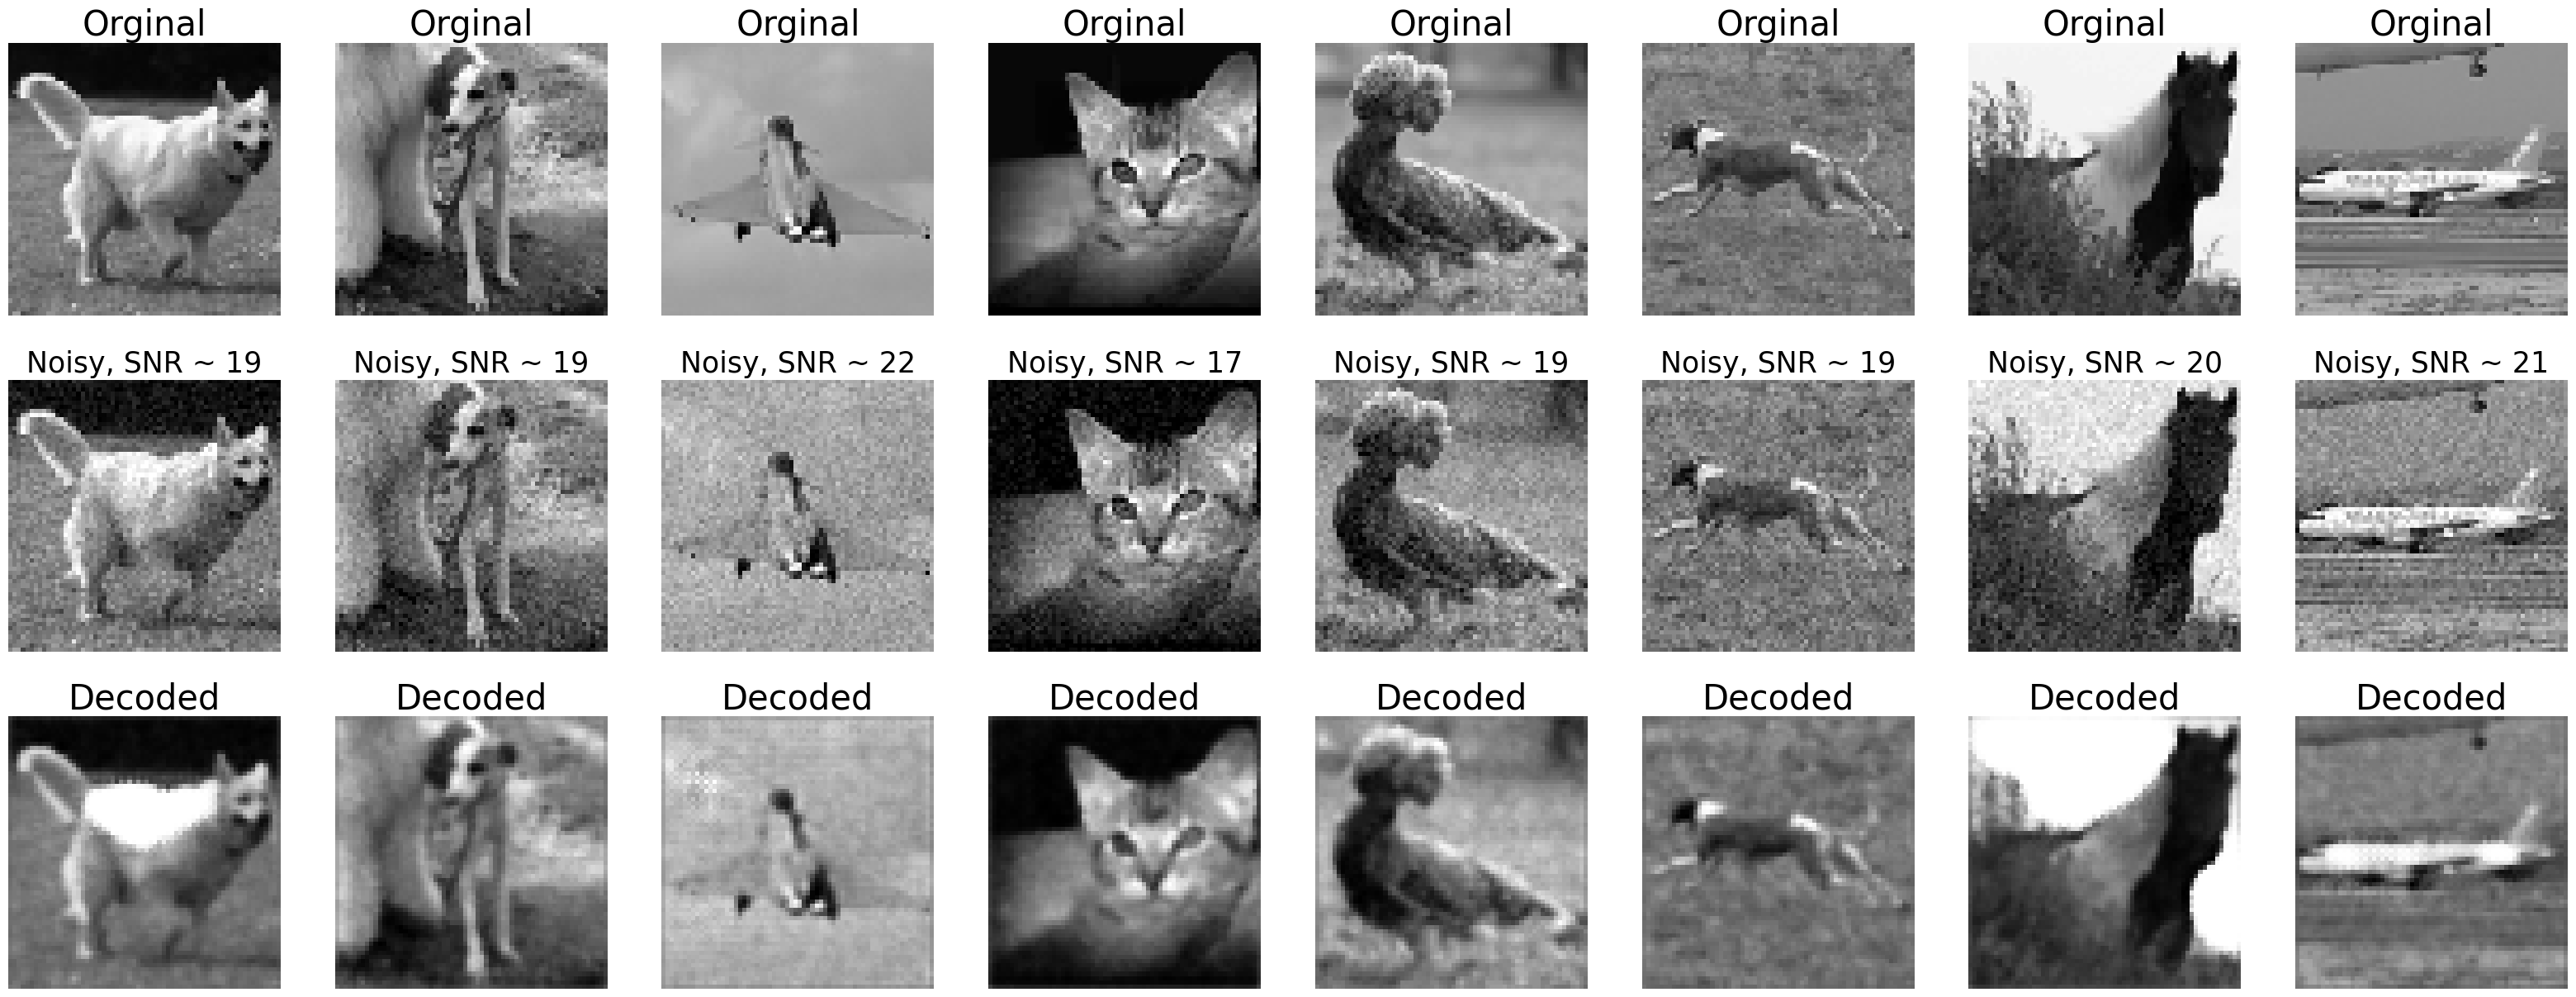

In [12]:
sigma = 0.05
test_noisy = nois_generator_for_test(test_batches,sigma)

X, y = next(test_noisy)
score = autoencoder.evaluate(X, y, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

decoded_imgs = autoencoder.predict(X)

SNR = []
for temp in y:
    S = (np.sum(np.power(temp,2))/temp.size)/(sigma**2)
    SNR.append(np.log10(S) * 10)

n = 8
plt.figure(figsize=(40, 15))
for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(y[i])
    plt.title("Orginal", fontsize=30)
    ax.axis('off')
    ax = plt.subplot(3, n, i+n + 1)
    plt.imshow(X[i])
    plt.title("Noisy, SNR ~ " + np.array2string(np.int8(SNR[i])), fontsize=25)

    ax.axis('off')
    ax = plt.subplot(3, n, i + n + n+ 1)
    plt.imshow(decoded_imgs[i])
    plt.title("Decoded", fontsize=30)
    ax.axis('off')
    
plt.show()

### TEST data with $\sigma$ = 0.1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.0045 - loss: 0.0049
Test loss: 0.004931233823299408
Test accuracy: 0.00445556640625
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
[np.float32(13.8054085), np.float32(15.99264), np.float32(14.89217), np.float32(11.542744), np.float32(13.527868), np.float32(15.190546), np.float32(13.859539), np.float32(13.891906)]


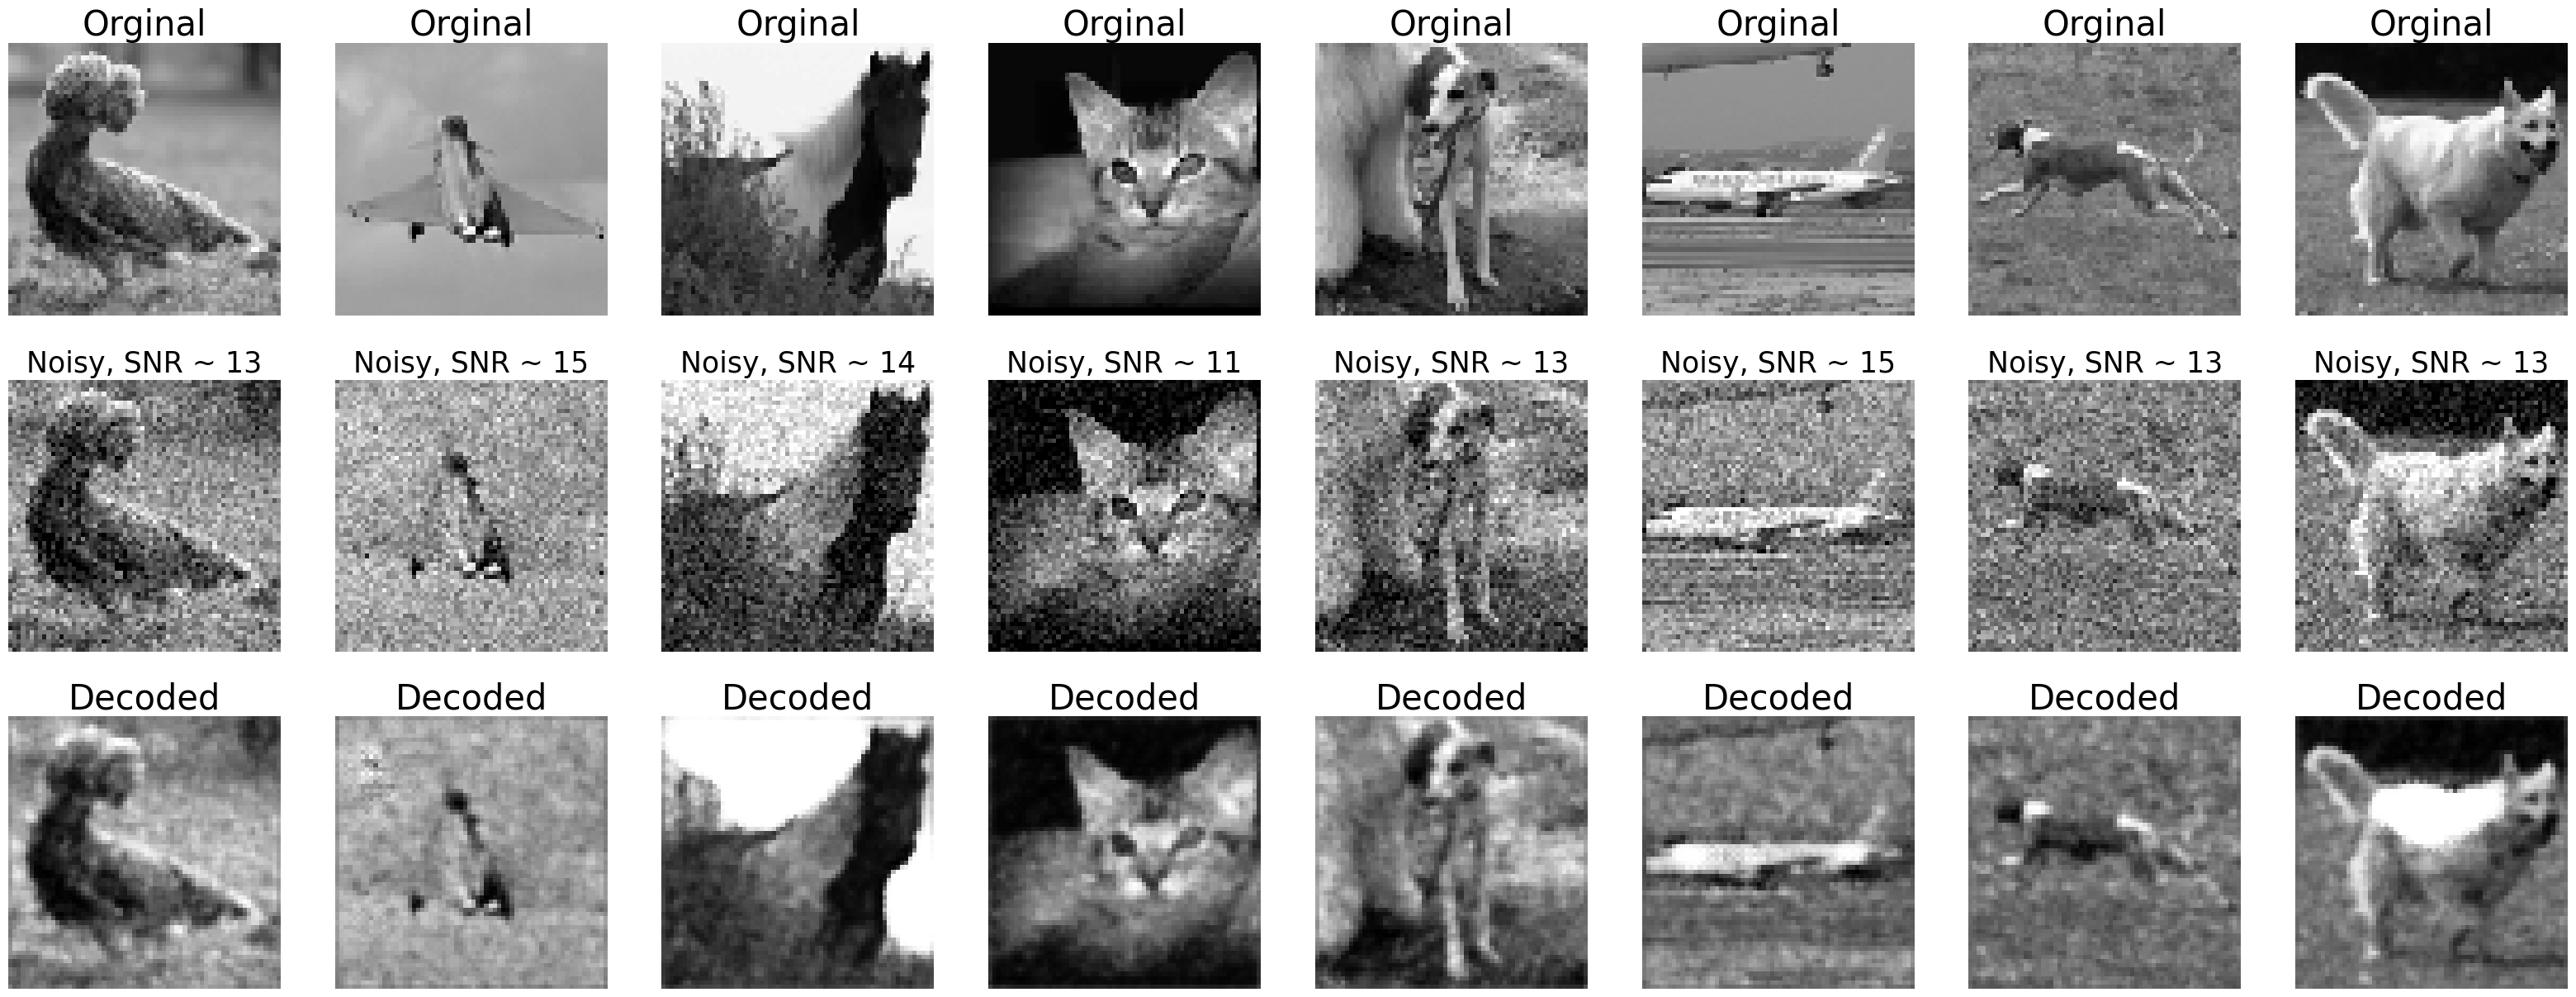

In [13]:
sigma = 0.1
test_noisy = nois_generator_for_test(test_batches,sigma)


X, y = next(test_noisy)
score = autoencoder.evaluate(X, y, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

decoded_imgs = autoencoder.predict(X)
SNR = []
for temp in y:
    S = (np.sum(np.power(temp,2))/temp.size)/(sigma**2)
    SNR.append(np.log10(S) * 10)
print(SNR)
n = 8
plt.figure(figsize=(40, 15))
for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(y[i])
    plt.title("Orginal", fontsize=30)
    ax.axis('off')
    ax = plt.subplot(3, n, i+n + 1)
    plt.imshow(X[i])
    plt.title("Noisy, SNR ~ " + np.array2string(np.int8(SNR[i])), fontsize=25)

    ax.axis('off')
    ax = plt.subplot(3, n, i + n + n+ 1)
    plt.imshow(decoded_imgs[i])
    plt.title("Decoded", fontsize=30)
    ax.axis('off')

plt.show()